In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import libraries and some constants

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd

path_prefix = '/AL/Phd/maxml/caloml-atlas/'
plotpath = path_prefix+'regression/Plots_mix/'
modelpath_c = path_prefix+'classifier/Models/'
modelpath = path_prefix+'regression/Models/'
# %config InlineBackend.figure_format = 'svg'

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]

In [3]:
# import our resolution utilities

import sys
sys.path.append(path_prefix)
from  util import resolution_util as ru
from  util import plot_util as pu
from  util import ml_util as mu
import uproot as ur

Using TensorFlow backend.


In [4]:
# import pi+

inputpath = path_prefix+'inputs/'
ptypes = ["pi0", "piplus"]
trees = {
    ptype : ur.open(inputpath+ptype+'.root')['ClusterTree']
    for ptype in ptypes
}
branches = ['clusterIndex', 'truthE', 'nCluster', 'clusterE', 'clusterECalib', 'clusterPt', 'clusterEta', 'clusterPhi', 'cluster_nCells', 'cluster_sumCellE', 'cluster_ENG_CALIB_TOT', 'cluster_ENG_CALIB_OUT_T', 'cluster_ENG_CALIB_DEAD_TOT', 'cluster_EM_PROBABILITY', 'cluster_HAD_WEIGHT', 'cluster_CENTER_MAG', 'cluster_FIRST_ENG_DENS', 'cluster_cellE_norm']
pdata = {
    ptype : itree.pandas.df(branches, flatten=False)
    for ptype, itree in trees.items()
}

print("Number of pi0 events: {}".format(len(pdata['pi0'])))
print("Number of pi+ events: {}".format(len(pdata['piplus'])))

Number of pi0 events: 263891
Number of pi+ events: 435967


In [5]:
#define convenience columns
for ptype in ptypes:
    pdata[ptype]['clusterEoverCalib'] = pdata[ptype].clusterE / pdata[ptype].cluster_ENG_CALIB_TOT
    pdata[ptype]['clusterEoverTruth'] = pdata[ptype].clusterE / pdata[ptype].truthE
    pdata[ptype]['cluster_ENG_ALL'] = pdata[ptype].cluster_ENG_CALIB_TOT + pdata[ptype].cluster_ENG_CALIB_OUT_T + pdata[ptype].cluster_ENG_CALIB_DEAD_TOT

In [6]:
# regression variables: define up here to make it easier for later swapping

for ptype in ptypes:
    pdata[ptype]['logE'] = np.log(pdata[ptype].clusterE)
    pdata[ptype]['logECalib'] = np.log(pdata[ptype].cluster_ENG_CALIB_TOT)
    pdata[ptype]['logECalibAll'] = np.log(pdata[ptype].cluster_ENG_ALL)

In [7]:
from sklearn.preprocessing import StandardScaler

scaler_cal = {}
for ptype in ptypes:
    # create scaler
    scaler_e = StandardScaler()
    scaler_cal[ptype] = StandardScaler()
    scaler_calAll = StandardScaler()
    # fit and transform in one step
    pdata[ptype]['s_logE'] = scaler_e.fit_transform(pdata[ptype]['logE'].to_numpy().reshape(-1,1))
    pdata[ptype]['s_logECalib'] = scaler_cal[ptype].fit_transform(pdata[ptype]['logECalib'].to_numpy().reshape(-1,1))
    pdata[ptype]['s_logECalibAll'] = scaler_calAll.fit_transform(pdata[ptype]['logECalibAll'].to_numpy().reshape(-1,1))


In [8]:
# fun cleaning for EMProb
epsilon = 0.000000000001

for ptype in ptypes:
    pdata[ptype]['cluster_fixEM'] = pdata[ptype].cluster_EM_PROBABILITY.replace(to_replace=0,value=epsilon)

In [9]:
for ptype in ptypes:
    pdata[ptype]['cluster_logEM'] = np.log(pdata[ptype].cluster_fixEM)

    scaler_EM = StandardScaler()
    pdata[ptype]['s_logEM'] = scaler_EM.fit_transform(pdata[ptype].cluster_logEM.to_numpy().reshape(-1,1))

    scaler_eta = StandardScaler()
    pdata[ptype]['s_eta'] = scaler_eta.fit_transform(pdata[ptype].clusterEta.to_numpy().reshape(-1,1))

    pdata[ptype]['logCenter'] = np.log(pdata[ptype].cluster_CENTER_MAG)
    scaler_center = StandardScaler()
    pdata[ptype]['s_logCenter'] = scaler_center.fit_transform(pdata[ptype].logCenter.to_numpy().reshape(-1,1))

    scaler_density = StandardScaler()
    pdata[ptype]['s_Density'] = scaler_density.fit_transform(pdata[ptype].cluster_FIRST_ENG_DENS.to_numpy().reshape(-1,1))

In [10]:
# define convience sub-frames

for ptype in ptypes:
    pdata[ptype]['Single'] = pdata[ptype].nCluster==1 # define a subset of events with only one cluster
    mu.splitFrameTVT(pdata[ptype], trainfrac = 0.7)   # define a train/test fraction of 70/20% (10% for val at this point)

In [11]:
from tensorflow.keras import regularizers
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import load_model

In [12]:
import tensorflow as tf

strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [13]:
All_input = {}

for ptype in ptypes:
    EMB1_cells = mu.setupCells(trees[ptype], 'EMB1') # implicitly flatten
    EMB2_cells = mu.setupCells(trees[ptype], 'EMB2')
    EMB3_cells = mu.setupCells(trees[ptype], 'EMB3') # implicitly flatten

    TileBar0_cells = mu.setupCells(trees[ptype], 'TileBar0') # implicitly flatten
    TileBar1_cells = mu.setupCells(trees[ptype], 'TileBar1') # implicitly flatten
    TileBar2_cells = mu.setupCells(trees[ptype], 'TileBar2') # implicitly flatten

    combine_All_cells = np.concatenate((EMB1_cells, EMB2_cells, EMB3_cells, TileBar0_cells, TileBar1_cells, TileBar2_cells), axis=1)
    s_All_cells, scaler_All_cells = mu.standardCells(combine_All_cells, ['EMB1', 'EMB2', 'EMB3', 'TileBar0', 'TileBar1', 'TileBar2'])
    All_input[ptype] = np.column_stack((pdata[ptype]['s_logE'],pdata[ptype]['s_eta'],s_All_cells))

## Load networks

In [14]:
def baseline_nn_All_model():
    number_pixels = 512 + 256 + 128 + 16 + 16 +8
    # create model
    with strategy.scope():    
        model = Sequential()
        used_pixels = number_pixels + 2
#     if number_pixels < 128:
#         used_pixels = 128
        model.add(Dense(used_pixels, input_dim=used_pixels, kernel_initializer='normal', activation='relu'))
        # model.add(Dropout(0.2))
        model.add(Dense(used_pixels, activation='relu'))
        # model.add(Dropout(0.2))
        model.add(Dense(int(used_pixels/2), activation='relu'))
        # model.add(Dropout(0.2))
        model.add(Dense(units=1, kernel_initializer='normal', activation='linear'))
        opt = Adam(lr=1e-4, decay=1e-6)
        model.compile(optimizer=opt, loss='mse',metrics=['mae','mse'])
    return model

In [15]:
regressor_All = {}
for ptype in ptypes:
    regressor_All[ptype] = KerasRegressor(build_fn=baseline_nn_All_model, batch_size=200*ngpu, epochs=100, verbose=1)
print(baseline_nn_All_model().summary())

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 938)               880782    
_________________________________________________________________
dense_1 (Dense)              (None, 938)               880782    
_________________________________________________________________
dense_2 (Dense)         

In [16]:
for ptype, m_name in zip(ptypes, ['all_0.h5', 'all.h5']):
    regressor_All[ptype].model = load_model(modelpath + m_name)

In [17]:
results = {}
results_EoverCalib = {}
for ptype_model in ptypes: # iterate over regression models
    results[ptype_model] = {}
    results_EoverCalib[ptype_model] = {}
    for ptype_data in ptypes: # iterate over data pion types
        print(ptype_model,ptype_data)
        results[ptype_model][ptype_data] = np.exp(scaler_cal[ptype_data].inverse_transform(regressor_All[ptype_model].predict(All_input[ptype_data])))
        results_EoverCalib[ptype_model][ptype_data] = results[ptype_model][ptype_data] / pdata[ptype_data].cluster_ENG_CALIB_TOT

pi0 pi0
263891/263891 [==============================] - 2s 9us/sample
pi0 piplus
435967/435967 [==============================] - 3s 7us/sample
piplus pi0
263891/263891 [==============================] - 2s 7us/sample
piplus piplus
435967/435967 [==============================] - 3s 8us/sample


<Figure size 576x432 with 0 Axes>

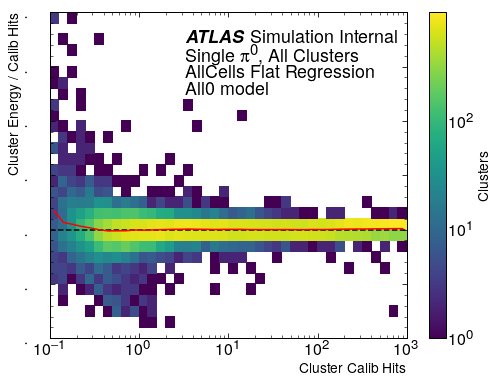

<Figure size 576x432 with 0 Axes>

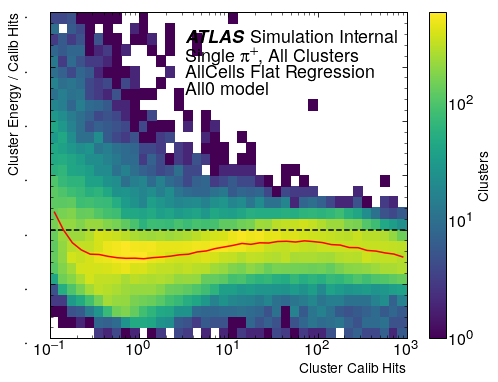

<Figure size 576x432 with 0 Axes>

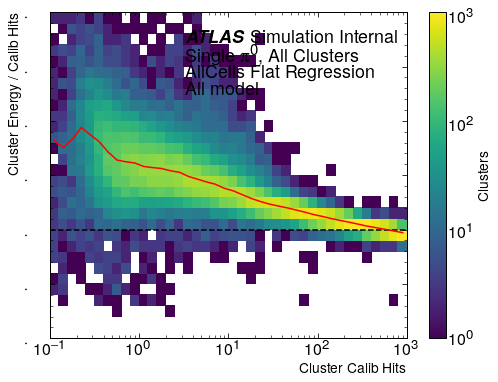

<Figure size 576x432 with 0 Axes>

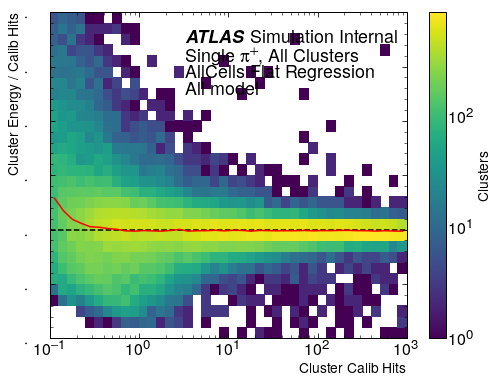

In [23]:
medReg = {}
for ptype_model, mlabel in zip(ptypes, ['0','']): # iterate over regression models
    medReg[ptype_model] = {}
    for ptype_data, plabel in zip(ptypes, ['0', '+']): # iterate over data pion types
        xcenter, medReg[ptype_model][ptype_data] = ru.responsePlot(
            pdata[ptype_data][pdata[ptype_data].test].cluster_ENG_CALIB_TOT,
            results_EoverCalib[ptype_model][ptype_data].to_numpy()[pdata[ptype_data].test],
            plotpath+'hist_2D_calib_vs_ratioReg_all'+mlabel+'_'+ptype_data+'.pdf',
            'median',
            atlas_x = 0.38, atlas_y = 0.95, simulation = True,
            textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{'+plabel+'}$, All Clusters'},
                        {'x': 0.38, 'y': 0.8,  'text': 'AllCells Flat Regression'},
                        {'x': 0.38, 'y': 0.75, 'text': 'All'+mlabel+' model'}])

<Figure size 576x432 with 0 Axes>

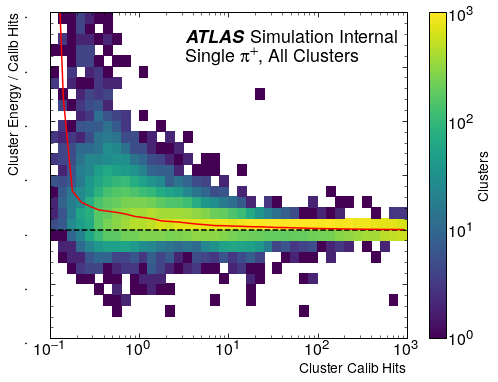

<Figure size 576x432 with 0 Axes>

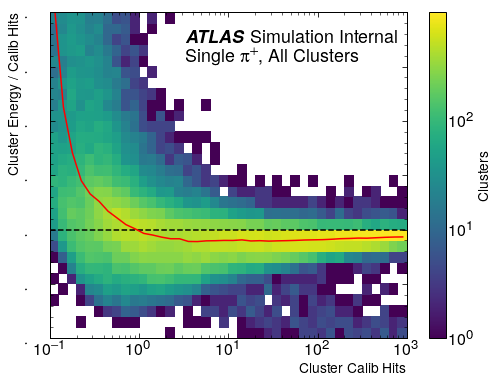

In [24]:
medBase = {}
for ptype in ptypes:
    xcenter, medBase[ptype] = ru.responsePlot(pdata[ptype][pdata[ptype].test].cluster_ENG_CALIB_TOT, 
                      pdata[ptype][pdata[ptype].test].clusterEoverCalib, 
                      #figfile = plotpath+'hist_2D_calib_vs_ratio_pp_profile.pdf', 
                      statistic = 'median',
                      atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                      textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'}])

<Figure size 576x432 with 0 Axes>

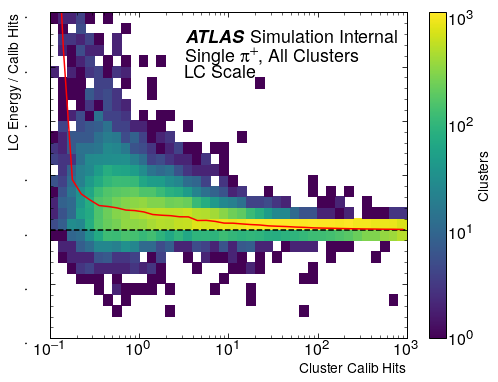

<Figure size 576x432 with 0 Axes>

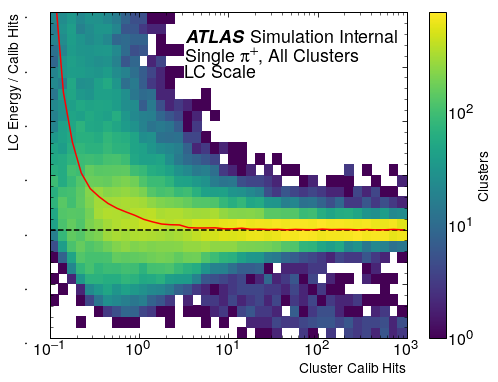

In [30]:
medLC = {}
xc = {}
for ptype in ptypes:
    pdata[ptype]['clusterHadE'] = pdata[ptype].clusterE * pdata[ptype].cluster_HAD_WEIGHT
    pdata[ptype]['clusterHadEoverCalib'] = pdata[ptype].clusterHadE / pdata[ptype].cluster_ENG_CALIB_TOT
    
    xc[ptype], medLC[ptype] = ru.responsePlot(pdata[ptype][pdata[ptype].test].cluster_ENG_CALIB_TOT, 
                        pdata[ptype][pdata[ptype].test].clusterHadEoverCalib,
                        #plotpath+'hist_2D_calib_vs_lc_pp_profile',
                        statistic = 'median',
                        xlabel = 'Cluster Calib Hits', ylabel = 'LC Energy / Calib Hits',
                        atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                        textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                                  {'x': 0.38, 'y': 0.8,  'text': 'LC Scale'}])

<Figure size 576x432 with 0 Axes>

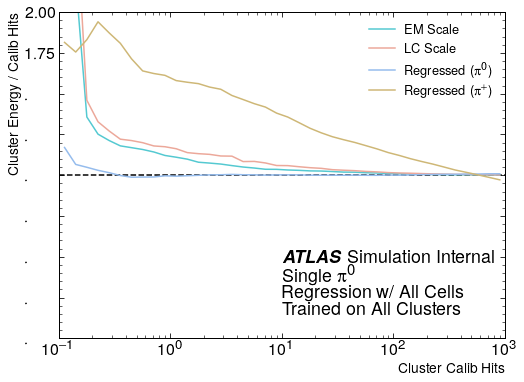

<Figure size 576x432 with 0 Axes>

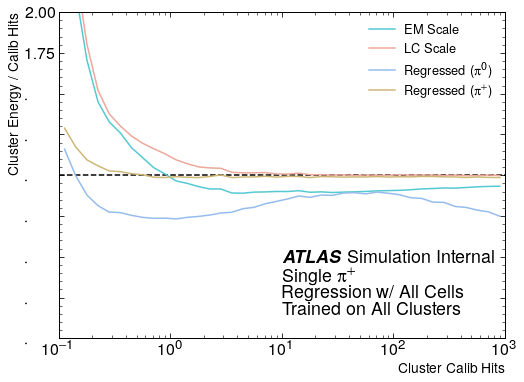

In [33]:
for ptype, plabel in zip(ptypes,['0','+']):
    pu.lineOverlay(xcenter=xc[ptype], lines = [medBase[ptype], medLC[ptype], medReg['pi0'][ptype], medReg['piplus'][ptype]],
                                    labels = ['EM Scale', 'LC Scale', 'Regressed ($\pi^{0}$)', 'Regressed ($\pi^{+}$)'],
                    xlabel = 'Cluster Calib Hits', ylabel = 'Cluster Energy / Calib Hits',
                    figfile = plotpath + "regressionmix_overlay_"+ptype+".pdf",
                    y_max = 2.0,
                    extra_lines = [[[0.1,1000],[1,1]]],
                    # linestyles = ['solid', 'dashed', 'solid', 'dashed', 'solid','dashed','solid','dashed','solid','dashed'], colorgrouping=2,
                    atlas_x = 0.5, atlas_y = 0.275, simulation = True,
                    textlist = [{'x': 0.5, 'y': 0.175, 'text': 'Single $\pi^{'+plabel+'}$'},
                                      {'x': 0.5, 'y': 0.125,  'text': 'Regression w/ All Cells'},
                                      {'x': 0.5, 'y': 0.075, 'text': 'Trained on All Clusters'}])